<a href="https://colab.research.google.com/github/boangri/uai-thesis-notebooks/blob/main/notebooks/ActorCritic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actor Critic

In [1]:
!pip install box2d-py

     |████████████████████████████████| 450kB 10.9MB/s 


In [2]:
!pip install pyvirtualdisplay 
!pip install xvfbwrapper 
!apt-get update 
!apt-get install xvfb

  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-cp37-none-any.whl size=5009 sha256=9c8a64577cd64a8741f01572c37df186824f640eab8fce3b6c800b6a7b087485
  Stored in directory: /root/.cache/pip/wheels/10/f2/61/cacfaf84b352c223761ea8d19616e3b5ac5c27364da72863f0
Successfully built xvfbwrapper
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Ign:10 https://developer

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import glob 
import io 
import base64 
from IPython.display import HTML 
import time 
from IPython import display as ipythondisplay 
from pyvirtualdisplay import Display 
import gym
from gym import wrappers
from gym import logger as gymlogger 
from gym.wrappers import Monitor 
gymlogger.set_level(40)
import json

## Classes & Functions

### ActorCriticNetwork

In [9]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, chkpt_dir, name):
        super().__init__()
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)
        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.pi = nn.Linear(fc2_dims, n_actions)
        self.v = nn.Linear(fc2_dims, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        pi = self.pi(x)
        v = self.v(x)

        return (pi, v)

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

### Agent

In [10]:
class Agent():
    def __init__(self, network, gamma):
        self.gamma = gamma
        self.actor_critic = network
        self.log_prob = None

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor_critic.device)
        logits, _ = self.actor_critic.forward(state)
        probabilities = F.softmax(logits, dim=1)
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        self.log_prob = log_prob
        h = -(probabilities * T.log(probabilities)).sum()

        return action.item(), h.item()
        # return action.item()

    def learn(self, state, reward, state_, done):
        self.actor_critic.optimizer.zero_grad()

        state = T.tensor([state], dtype=T.float).to(self.actor_critic.device)
        state_ = T.tensor([state_], dtype=T.float).to(self.actor_critic.device)
        reward = T.tensor(reward, dtype=T.float).to(self.actor_critic.device)

        _, critic_value = self.actor_critic.forward(state)
        _, critic_value_ = self.actor_critic.forward(state_)

        delta = reward + self.gamma*critic_value_*(1-int(done)) - critic_value

        actor_loss = -self.log_prob*delta
        critic_loss = delta**2

        (actor_loss + critic_loss).backward()
        self.actor_critic.optimizer.step()

        return actor_loss.to('cpu').detach().numpy(), critic_loss.to('cpu').detach().numpy()

    def save_model(self):
        self.actor_critic.save_checkpoint()
    
    def load_model(self):
        self.actor_critic.load_checkpoint()

### learn()

In [11]:
def learn(env, agent, n_games, history_file, freq=10):
    scores = []
    for i in range(n_games):
        done = False
        observation = env.reset()
        score = 0
        steps = 0
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            steps += 1
            observation = observation_
        scores.append(score)
        agent.learn()
        if (i + 1) % freq == 0:
            avg_score = np.mean(scores[-100:])
            print('episode ', i + 1, 'score %.1f avg score %.1f steps %d' % (score, avg_score, steps))
        with open(history_file,'a') as h:   
            h.write("%d,%.3f,%d\n" % (i + 1, score, steps)) 
    agent.save_model()

### test()

In [12]:
def test(env, agent, episodes=100):
    total = 0.
    for ep in range(episodes):
        score = 0.
        obs = env.reset()
        done = False
        while not done:
            action = agent.choose_action(obs)
            obs, reward, done, _ = env.step(action)
            score += reward
        if (ep + 1) % 10 == 0:
            print("episode: %d Score: %1.f" % (ep+1, score))
        total += score
    print("Average score %.2f" % (total/episodes))

### video()

In [13]:
display = Display(visible=0, size=(1400, 900))
display.start()

def video(env, agent, dir, seed=42):
    env.seed(seed)
    env = wrap_env(env)
    obs = env.reset()
    done = False
    score = 0.
    while not done:
        env.render()
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(action)
        score += reward
    env.close()
    print("Score=%.2f" % score)
    show_video(dir)

def show_video(dir):    
    mp4list = glob.glob(os.path.join(dir, 'video/*.mp4'))
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
def wrap_env(env):
    env = Monitor(env, os.path.join(dir, 'video'), force=True)
    return env

### plot_history()

In [14]:
def plot_history(path):
    df = pd.read_csv(path + '.csv', header=None, names=('episode', 'score', 'steps'))
    x = df.episode
    y = df.score
    y1 = np.zeros_like(y)
    for i in range(len(x)):
        y1[i] = np.mean(y[i-100:i])
    steps = df.steps
    plt.figure(figsize=(12,12))
    plt.subplot(2, 1, 1)
    plt.plot(x, y, 'o', markersize=3, label='очки')
    plt.plot(x, y1, color='C1', label='среднее за 100')
    plt.ylabel('Очки')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    plt.title(f'История обучения - очки')
    plt.subplot(2, 1, 2)
    plt.plot(x, steps, 'o', markersize=3, color='C2', label='steps')
    plt.ylabel('шагов на эпизод')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    plt.title(f'История обучения - шаги')
    plt.show()

In [15]:
algo='ActorCritic'
home_dir = os.path.join('/content/drive/MyDrive/Thesys', algo)

## LunarLander-v2

### Гиперпараметры

In [ ]:
hp = dict(
    env_name='LunarLander-v2',
    algo=algo,
    id='03',
    horizon=20,
    avg_reward=1.,
    n_episodes=4000,
    n_steps=200,
    lr=0.001,
    layers=[256, 64],
)
env_name = hp['env_name']
dir = os.path.join(home_dir, env_name)
dir = os.path.join(dir, hp['id'])
path = os.path.join(dir, 'history')
!mkdir -p $dir 
with open(os.path.join(dir, "hp.json"), "w") as json_file:
    json.dump(hp, json_file)

In [ ]:
n_steps = hp['n_steps']
env = gym.make(env_name)

Nh = hp['horizon']
sf = hp['avg_reward'] * Nh 
gamma = 1 - 1/Nh
n_episodes = hp['n_episodes']
lr = hp['lr']
input_dims = env.observation_space.shape
n_actions = env.action_space.n
scores = []
policyNetwork = PolicyNetwork(ALPHA=lr, input_dims=input_dims, fc1_dims=256, fc2_dims=256, n_actions=n_actions, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=gamma)


### Обучение

In [ ]:
%%time
history_file = path + '.csv'
!rm -rf $history_file

freq = 10

for ep in range(n_episodes):
    done = False
    score = 0
    obs = env.reset()
    steps = 0
    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        agent.store_rewards(reward)
        obs = obs_
        score += reward
        steps += 1
    scores.append(score)
    loss = agent.learn()
    if (ep + 1) % freq == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', ep + 1, 'score %.3f avg score %.3f steps %d loss %.3f' % (score, avg_score, steps, loss/steps))
    with open(history_file,'a') as h:   
        h.write("%d,%.3f,%d\n" % (ep + 1, score, steps)) 
agent.save_model()

episode  10 score -391.321 avg score -169.540 steps 96 loss 0.081
episode  20 score -332.392 avg score -199.620 steps 103 loss 0.212
episode  30 score -130.479 avg score -174.512 steps 114 loss 0.124
episode  40 score -175.532 avg score -162.786 steps 101 loss -0.010
episode  50 score -28.108 avg score -167.684 steps 119 loss 0.019
episode  60 score -288.421 avg score -180.207 steps 132 loss 0.085
episode  70 score -78.915 avg score -177.725 steps 124 loss -0.046
episode  80 score -297.346 avg score -181.778 steps 125 loss 0.027
episode  90 score -224.117 avg score -176.796 steps 231 loss 0.025
episode  100 score -256.776 avg score -180.856 steps 129 loss 0.053
episode  110 score -277.514 avg score -191.628 steps 136 loss 0.014
episode  120 score -58.417 avg score -183.411 steps 120 loss -0.081
episode  130 score -63.623 avg score -178.595 steps 100 loss 0.093
episode  140 score -253.878 avg score -178.480 steps 96 loss -0.246
episode  150 score -31.872 avg score -173.777 steps 1000 lo

KeyboardInterrupt: ignored

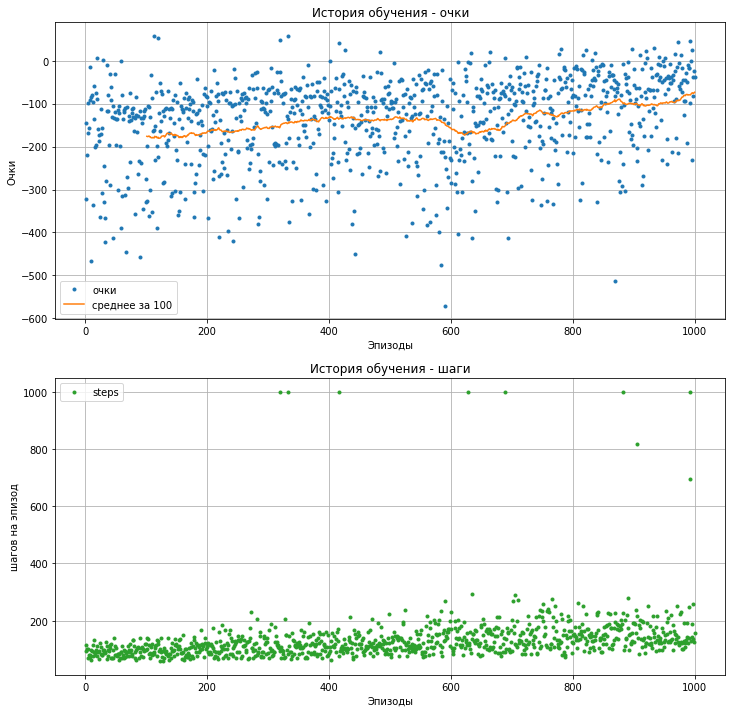

{'algo': 'reinforce',
 'avg_reward': 1.0,
 'env_name': 'LunarLander-v2',
 'horizon': 20,
 'id': '01',
 'layers': [256, 256],
 'lr': 0.0001,
 'n_episodes': 1000,
 'n_steps': 200}

In [ ]:
plot_history(path)
hp

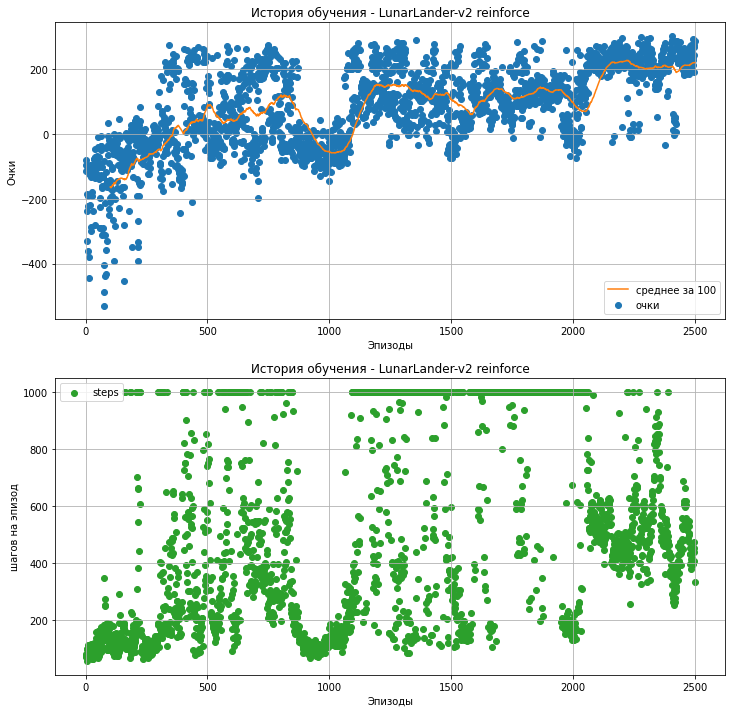

In [ ]:
plot_history(history_file)

In [ ]:
env = gym.make(env_name)
policyNetwork = PolicyNetwork(ALPHA=0.001, input_dims=env.observation_space.shape, fc1_dims=256, fc2_dims=256, n_actions=env.action_space.n, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=0.99)
agent.load_model()

... loading checkpoint ...


### Тестирование

In [ ]:
%%time
env = gym.make(env_name)
test(env, agent, episodes=100)

episode: 10 Score: -31.4
episode: 20 Score: -48.7
episode: 30 Score: -70.5
episode: 40 Score: 283.3
episode: 50 Score: -28.9
episode: 60 Score: -23.3
episode: 70 Score: -15.1
episode: 80 Score: -0.1
episode: 90 Score: -62.0
episode: 100 Score: 10.3
Average score 16.16
CPU times: user 22.8 s, sys: 530 ms, total: 23.4 s
Wall time: 23.4 s


### Video

In [ ]:
env = gym.make(env_name)
video(env, agent, seed=42)

Score=-57.22


## CartPole-v1

In [ ]:
env_name = 'CartPole-v0'
dir = os.path.join(home_dir, env_name)
history_file = os.path.join(dir, 'history.csv')
!mkdir -p $dir 

### Гиперпараметры

In [ ]:
%%time
history_file = os.path.join(dir, 'history.csv')
env = gym.make(env_name)
policyNetwork = PolicyNetwork(ALPHA=0.001, input_dims=env.observation_space.shape, fc1_dims=256, fc2_dims=256, n_actions=env.action_space.n, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=0.9)
scores = []
n_games = 2000
# for i in range(num_episodes):
#     done = False
#     score = 0
#     observation = env.reset()
#     steps = 0
#     while not done:
#         action = agent.choose_action(observation)
#         observation_, reward, done, info = env.step(action)
#         agent.store_rewards(reward)
#         observation = observation_
#         score += reward
#         steps += 1
#     scores.append(score)
#     agent.learn()
#     if (i + 1) % 100 == 0:
#         avg_score = np.mean(scores[-100:])
#         print('episode ', i + 1, 'score %.1f avg score %.1f steps %d' % (score, avg_score, steps))
#     with open(history_file,'a') as h:   
#         h.write("%d,%.3f,%d\n" % (i + 1, score, steps)) 
# agent.save_model()

episode  100 score 50.0 avg score 56.4 steps 50
episode  200 score 122.0 avg score 145.0 steps 122
episode  300 score 200.0 avg score 169.2 steps 200
episode  400 score 200.0 avg score 111.2 steps 200
episode  500 score 173.0 avg score 195.5 steps 173
... saving checkpoint ...
CPU times: user 1min 25s, sys: 955 ms, total: 1min 26s
Wall time: 1min 27s


### Обучение

In [ ]:
learn(env, agent, n_games, history_file)

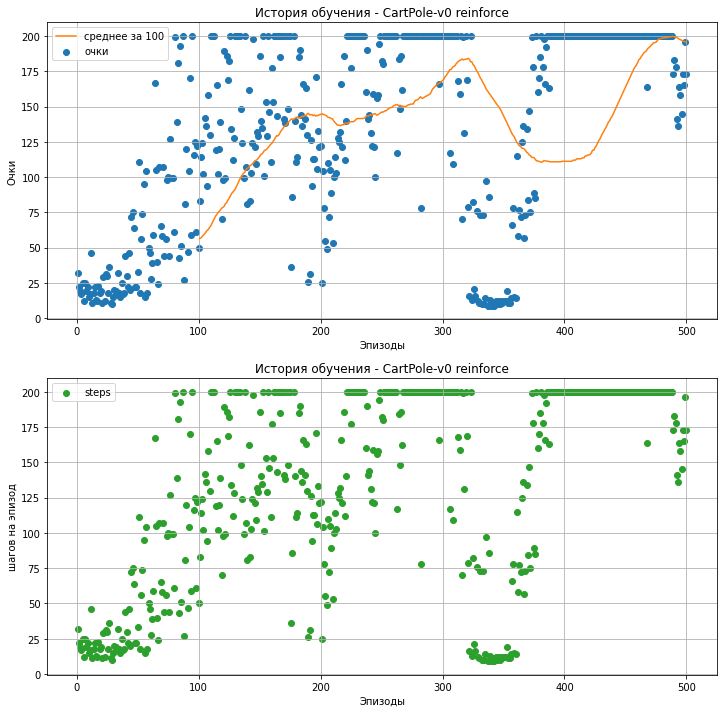

In [ ]:
plot_history(history_file)

In [ ]:
policyNetwork = PolicyNetwork(ALPHA=0.001, input_dims=env.observation_space.shape, fc1_dims=256, fc2_dims=256, n_actions=env.action_space.n, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=0.99)
agent.load_model()

... loading checkpoint ...


### Тестирование

In [ ]:
test(env, agent, episodes=100)

In [ ]:
%%time
env = gym.make(env_name)
episodes = 100
total = 0.
for ep in range(episodes):
    score = 0.
    obs = env.reset()
    done = False
    while not done:
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(action)
        score += reward
    if (ep + 1) % 10 == 0:
        print("episode: %d Score: %1.f" % (ep+1, score))
    total += score
print("Average score %.2f" % (total/episodes))

episode: 10 Score: 200
episode: 20 Score: 195
episode: 30 Score: 197
episode: 40 Score: 200
episode: 50 Score: 200
episode: 60 Score: 200
episode: 70 Score: 200
episode: 80 Score: 184
episode: 90 Score: 200
episode: 100 Score: 200
Average score 196.81
CPU times: user 15.7 s, sys: 498 ms, total: 16.2 s
Wall time: 16.2 s


### Video

In [ ]:
video(env, agent, seed=42)

In [ ]:
env = gym.make(env_name)
env.seed(1)
env = wrap_env(env)
obs = env.reset()
done = False
score = 0.
while not done:
    env.render()
    action = agent.choose_action(obs)
    obs, reward, done, _ = env.step(action)
    score += reward
env.close()
print("Score=%.2f" % score)
show_video()

Score=200.00


## GrandPrix-v0

In [16]:
!pip install gym-grand-prix

     |████████████████████████████████| 11.8MB 10.4MB/s 


In [17]:
import gym_grand_prix
from gym import spaces
from gym_grand_prix.wrappers import GrandPrixWrapper

GrandPrix-v0 version 0.2.3 20.3.2021


### Гиперпараметры

In [18]:
hp = dict(
    env_name='GrandPrix-v0',
    algo=algo,
    id='02',
    track=3,
    fine=10.,
    horizon=20,
    avg_reward=5.,
    n_episodes=2000,
    n_steps=200,
    lr=0.0003,
    layers=[256, 256],
)
env_name = hp['env_name']
dir = os.path.join(home_dir, env_name)
dir = os.path.join(dir, hp['id'])
path = os.path.join(dir, 'history')
!mkdir -p $dir 
with open(os.path.join(dir, "hp.json"), "w") as json_file:
    json.dump(hp, json_file)

In [19]:
with open(os.path.join(dir, "hp.json"), "r") as read_file: 
    hp1 = json.load(read_file)
hp1

{'algo': 'ActorCritic',
 'avg_reward': 5.0,
 'env_name': 'GrandPrix-v0',
 'fine': 10.0,
 'horizon': 20,
 'id': '02',
 'layers': [256, 256],
 'lr': 0.0003,
 'n_episodes': 2000,
 'n_steps': 200,
 'track': 3}

In [20]:
fine = hp['fine']
track = hp['track']
n_steps = hp['n_steps']
n_rays = 5
env = gym.make(env_name)
env = GrandPrixWrapper(env, steps_per_episode=n_steps, fine=fine)

options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}

Nh = hp['horizon']
sf = hp['avg_reward'] * Nh 
gamma = 1 - 1/Nh
n_episodes = hp['n_episodes']
lr = hp['lr']
input_dims = env.observation_space.shape
n_actions = env.action_space.n
scores = []

network = ActorCriticNetwork(lr=lr, input_dims=input_dims, fc1_dims=hp['layers'][0], fc2_dims=hp['layers'][1], n_actions=n_actions, chkpt_dir=dir, name='model.pt')
agent = Agent(network, gamma=gamma)


pygame 2.0.1 (SDL 2.0.14, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Обучение

In [21]:
%%time
history_file = path + '.csv'
!rm -rf $history_file

freq = 2000 // n_steps

obs = env.reset(options=options)
for ep in range(n_episodes):
    done = False
    score = 0
    obs = env.reset()
    collisions = 0
    steps = 0
    actor_losses = []
    critic_losses = []
    entropies = []
    while not done:
        action, entropy = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        actor_loss, critic_loss = agent.learn(obs, reward, obs_, done)
        actor_losses.append(actor_loss)
        critic_losses.append(critic_loss)
        entropies.append(entropy)
        obs = obs_
        score += reward / n_steps
        if 'collision' in info and info['collision']:
            collisions += 1
        steps += 1
    scores.append(score)
    avg_actor_loss = np.mean(actor_losses)
    avg_critic_loss = pow(np.mean(critic_losses), 0.5)
    avg_entropy = np.mean(entropies)
    if (ep + 1) % freq == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', ep + 1, 'score %.3f avg score %.3f steps %d coll %d actor_loss %.3f critic_loss %.3f avg_entropy %.3f' 
              % (score, avg_score, steps, collisions, avg_actor_loss, avg_critic_loss, avg_entropy))
    with open(history_file,'a') as h:   
        h.write("%d,%.3f,%d\n" % (ep + 1, score, steps)) 
agent.save_model()

episode  10 score -4.794 avg score -1.286 steps 200 coll 9 actor_loss -3.420 critic_loss 5.722 avg_entropy 0.709
episode  20 score -2.039 avg score -1.299 steps 200 coll 11 actor_loss -2.732 critic_loss 4.900 avg_entropy 0.545
episode  30 score -2.633 avg score -2.021 steps 200 coll 14 actor_loss -0.214 critic_loss 2.387 avg_entropy 0.047
episode  40 score -3.625 avg score -2.416 steps 200 coll 14 actor_loss -0.003 critic_loss 3.151 avg_entropy 0.011
episode  50 score -1.010 avg score -2.428 steps 200 coll 0 actor_loss -0.125 critic_loss 1.006 avg_entropy 0.174
episode  60 score -1.144 avg score -2.193 steps 200 coll 3 actor_loss -0.206 critic_loss 1.679 avg_entropy 0.078
episode  70 score -1.001 avg score -2.024 steps 200 coll 0 actor_loss -0.049 critic_loss 0.829 avg_entropy 0.006
episode  80 score -1.000 avg score -1.896 steps 200 coll 0 actor_loss -0.001 critic_loss 0.794 avg_entropy 0.017
episode  90 score -1.038 avg score -1.798 steps 200 coll 0 actor_loss -0.000 critic_loss 0.85

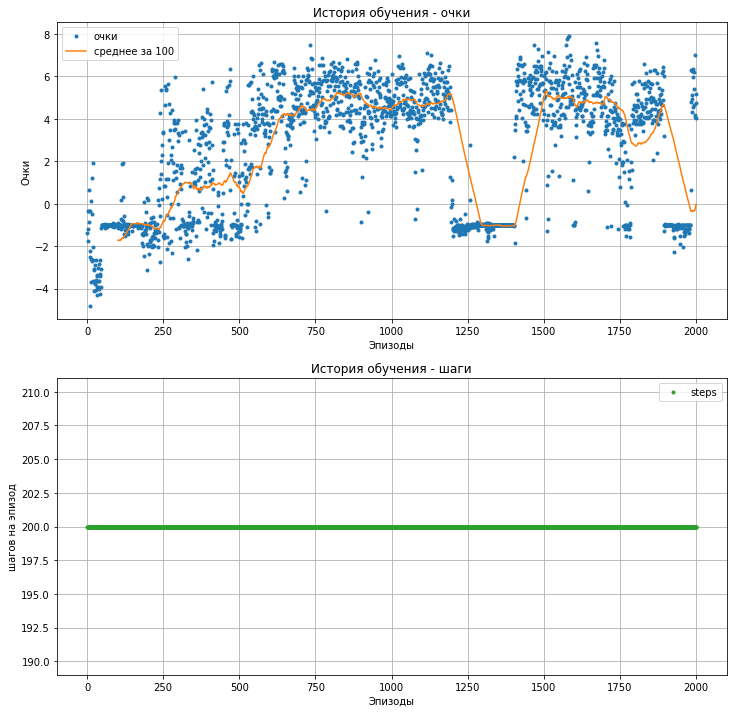

{'algo': 'ActorCritic',
 'avg_reward': 5.0,
 'env_name': 'GrandPrix-v0',
 'fine': 10.0,
 'horizon': 20,
 'id': '02',
 'layers': [256, 256],
 'lr': 0.0003,
 'n_episodes': 2000,
 'n_steps': 200,
 'track': 3}

In [22]:
plot_history(path)
hp

### Тестирование

In [ ]:
policyNetwork = PolicyNetwork(ALPHA=lr, input_dims=input_dims, fc1_dims=256, fc2_dims=256, n_actions=n_actions, chkpt_dir=dir, name='model.pt')
agent = PolicyGradientAgent(policyNetwork, GAMMA=gamma)
agent.load_model()

... loading checkpoint ...


In [ ]:
%%time
track = 3
n_rays = 5
n_steps = 2000
env = gym.make(env_name)
env = GrandPrixWrapper(env, fine=0., steps_per_episode=n_steps)
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}
episodes = 10
total = 0.
total_coll = 0
obs = env.reset(options=options)
v = []
for ep in range(episodes):
    score = 0.
    collisions = 0
    obs = env.reset()
    done = False
    while not done:
        action = agent.choose_action(obs)
        obs, reward, done, info = env.step(action)
        v.append(obs[0])
        score += reward/n_steps
        if 'collision' in info and info['collision']:
            collisions += 1
    if (ep + 1) % 1 == 0:
        print("episode: %d Score: %.3f Collisions: %d" % (ep+1, score, collisions))
    total += score
    total_coll += collisions
print("Average score %.3f Avg collisions: %.3f" % (total/episodes, total_coll/episodes))
v = np.array(v)
print('Vmax:%.3f Vmean:%.3f Vstd:%.3f' % (v.max(), v.mean(), v.std()))

episode: 1 Score: 5.491 Collisions: 27
episode: 2 Score: 5.440 Collisions: 28
episode: 3 Score: 5.964 Collisions: 29
episode: 4 Score: 5.577 Collisions: 29
episode: 5 Score: 5.471 Collisions: 29
episode: 6 Score: 5.668 Collisions: 29
episode: 7 Score: 5.828 Collisions: 29
episode: 8 Score: 5.692 Collisions: 31
episode: 9 Score: 5.273 Collisions: 28
episode: 10 Score: 5.730 Collisions: 28
Average score 5.613 Avg collisions: 28.700
Vmax:3.188 Vmean:1.492 Vstd:0.709
CPU times: user 1min 47s, sys: 385 ms, total: 1min 48s
Wall time: 1min 48s


### Video

In [ ]:
track = 3
n_rays = 5
n_steps = 2000
env = gym.make(env_name)
env = GrandPrixWrapper(env, fine=0., steps_per_episode=n_steps )
env = Monitor(env, os.path.join(dir, 'video'), force=True)

options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
    'display': 1
}

obs = env.reset(options=options)
done = False
score = 0.
while not done:
    env.render()
    action = agent.choose_action(obs)
    obs, reward, done, _ = env.step(action)
    score += reward/n_steps
env.close()
print("Score=%.3f" % score)
show_video(dir)
hp

Score=5.641


{'algo': 'reinforce',
 'avg_reward': 5.0,
 'env_name': 'GrandPrix-v0',
 'fine': 100.0,
 'horizon': 20,
 'id': '02',
 'layers': [256, 256],
 'lr': 0.0001,
 'n_episodes': 2000,
 'n_steps': 200,
 'track': 3}

#End